/var/folders/sq/hswbnn3150161ws0cz9xkh3m0000gn/T/ipykernel_3865/2326813451.py:12: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)



=== Popular Routes ===


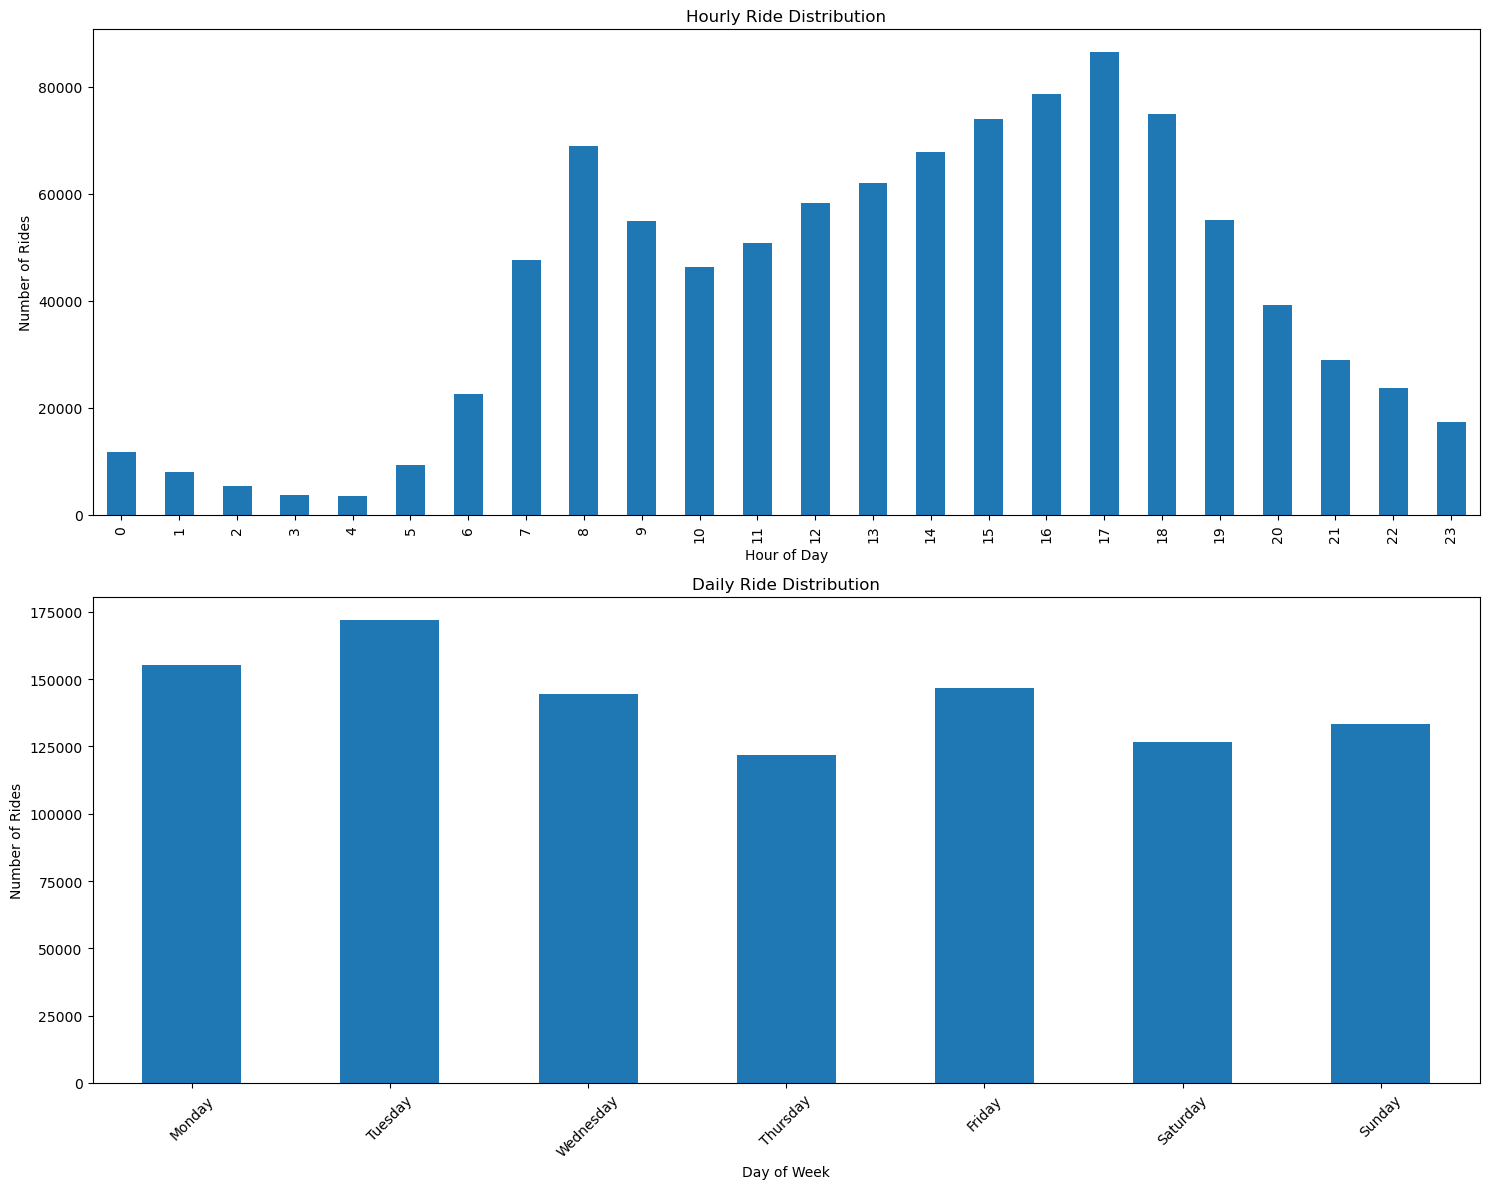

route
Norfolk St & Broome St to Henry St & Grand St                             407
Roosevelt Island Tramway to Roosevelt Island Tramway                      315
Vernon Blvd & 50 Ave to Franklin St & Dupont St                           314
Grand Army Plaza & Central Park S to Grand Army Plaza & Central Park S    303
Henry St & Grand St to Norfolk St & Broome St                             300
Division Ave & Marcy Ave to Division Ave & Marcy Ave                      293
E 2 St & Avenue C to E 1 St & 1 Ave                                       281
Amsterdam Ave & W 73 St to Amsterdam Ave & W 79 St                        275
Broadway & Berry St to N 6 St & Bedford Ave                               265
S 4 St & Wythe Ave to N 6 St & Bedford Ave                                259
Name: count, dtype: int64

=== Demographics Analysis ===


<Figure size 1200x600 with 0 Axes>

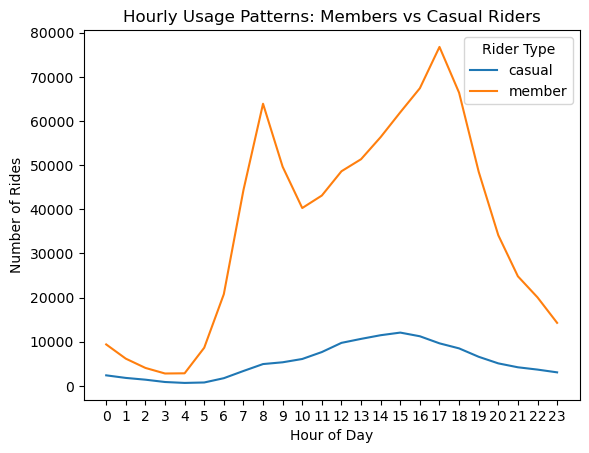

              trip_duration                \
                      count   mean median   
member_casual                               
casual               133177  38.75  11.86   
member               866823  13.12   7.97   

                                                   rideable_type  
                                                        <lambda>  
member_casual                                                     
casual           {'electric_bike': 73284, 'classic_bike': 59893}  
member         {'classic_bike': 433842, 'electric_bike': 432981}  

=== Station Utilization ===


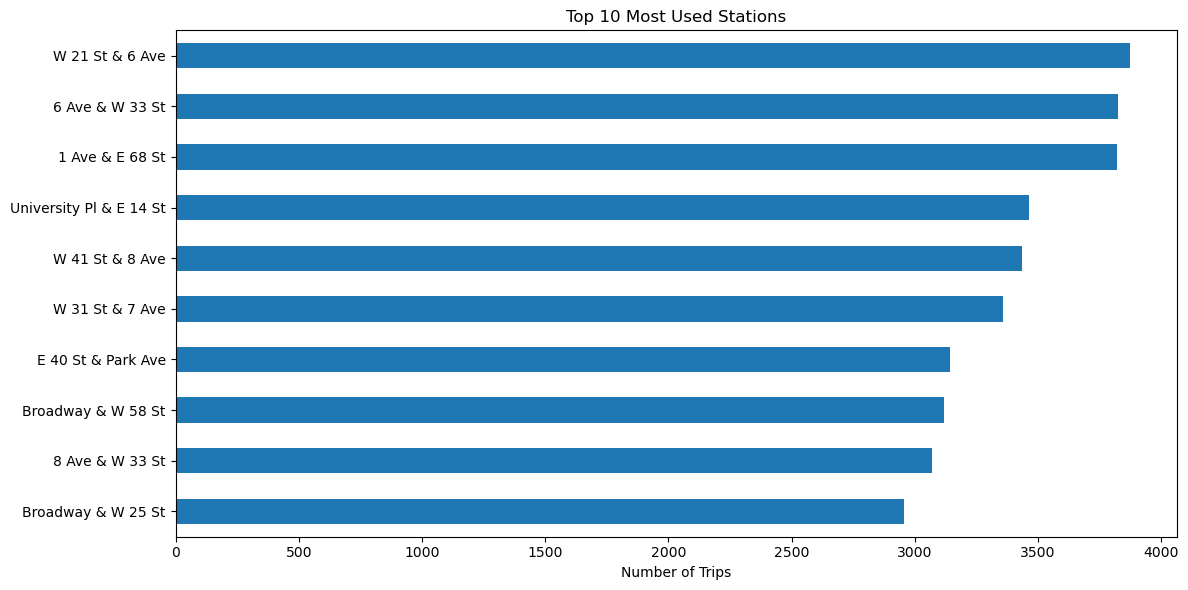

                         total_starts  avg_trip_duration  total_ends  net_flow
W 21 St & 6 Ave                3873.0          11.967071      8575.0   -4702.0
6 Ave & W 33 St                3825.0          15.325805         7.0    3818.0
1 Ave & E 68 St                3823.0          13.292117         0.0    3823.0
University Pl & E 14 St        3462.0          13.992578      1083.0    2379.0
W 41 St & 8 Ave                3436.0          11.895115      5710.0   -2274.0
W 31 St & 7 Ave                3360.0          13.716017      3326.0      34.0
E 40 St & Park Ave             3144.0          13.109848      5701.0   -2557.0
Broadway & W 58 St             3120.0          16.451800         0.0    3120.0
8 Ave & W 33 St                3069.0          13.724702      1402.0    1667.0
Broadway & W 25 St             2955.0          16.546126         1.0    2954.0

=== Summary Statistics ===
Total number of rides: 1,000,000
Average trip duration: 16.54 minutes
Number of unique stations: 1730


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def load_and_clean_data(filepath):
    """
    Load and perform initial cleaning of the CitiBike data
    """
    # Read the CSV file
    df = pd.read_csv(filepath)
    
    # Convert timestamp columns to datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    
    # Calculate trip duration in minutes
    df['trip_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
    
    # Extract time components
    df['start_hour'] = df['started_at'].dt.hour
    df['start_day'] = df['started_at'].dt.day_name()
    df['start_month'] = df['started_at'].dt.month
    df['start_date'] = df['started_at'].dt.date
    
    return df

def analyze_ride_patterns(df):
    """
    Analyze riding patterns including popular routes and peak times
    """
    # Popular routes
    df['route'] = df['start_station_name'] + ' to ' + df['end_station_name']
    popular_routes = df['route'].value_counts().head(10)
    
    # Peak times analysis
    hourly_rides = df['start_hour'].value_counts().sort_index()
    
    # Fixed daily rides analysis
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_rides = df['start_day'].value_counts()
    daily_rides = daily_rides.reindex(day_order)
    
    # Plot findings
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Hourly distribution
    hourly_rides.plot(kind='bar', ax=ax1)
    ax1.set_title('Hourly Ride Distribution')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Number of Rides')
    
    # Daily distribution
    daily_rides.plot(kind='bar', ax=ax2)
    ax2.set_title('Daily Ride Distribution')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Number of Rides')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return popular_routes

def analyze_demographics(df):
    """
    Analyze user demographics and behavior patterns
    """
    # Member vs Casual analysis
    member_stats = df.groupby('member_casual').agg({
        'trip_duration': ['count', 'mean', 'median'],
        'rideable_type': lambda x: x.value_counts().to_dict()
    }).round(2)

    # Time patterns by user type - modified to transpose the data
    hourly_by_type = df.groupby(['member_casual', 'start_hour']).size().unstack(level=0, fill_value=0)
    
    # Plot member vs casual patterns
    plt.figure(figsize=(12, 6))
    hourly_by_type.plot(kind='line')
    plt.title('Hourly Usage Patterns: Members vs Casual Riders')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Rides')
    plt.legend(title='Rider Type')
    
    # Add proper x-axis ticks
    plt.xticks(range(24), range(24))
    
    plt.show()
    return member_stats

def analyze_station_utilization(df):
    """
    Analyze station utilization rates
    """
    # Start station analysis - add dropna() to remove stations with NaN names
    start_station_stats = df.groupby('start_station_name').agg({
        'ride_id': 'count',
        'trip_duration': 'mean'
    }).dropna().rename(columns={'ride_id': 'total_starts', 'trip_duration': 'avg_trip_duration'})
    
    # End station analysis - add dropna() here too
    end_station_stats = df.groupby('end_station_name').agg({
        'ride_id': 'count'
    }).dropna().rename(columns={'ride_id': 'total_ends'})
    
    # Combine start and end statistics
    station_stats = pd.merge(start_station_stats, end_station_stats,
                           left_index=True, right_index=True, how='outer').fillna(0)
    station_stats['net_flow'] = station_stats['total_starts'] - station_stats['total_ends']
    
    # Create station utilization plot
    plt.figure(figsize=(12, 6))
    
    # Get top 10 stations and plot - make sure we have actual values
    top_10_stations = station_stats[station_stats['total_starts'] > 0].sort_values('total_starts', ascending=True).tail(10)
    
    ax = top_10_stations['total_starts'].plot(kind='barh')
    plt.yticks(range(len(top_10_stations)), top_10_stations.index)
    plt.title('Top 10 Most Used Stations')
    plt.xlabel('Number of Trips')
    plt.tight_layout()
    plt.show()
    
    return station_stats.sort_values('total_starts', ascending=False)
    
    return station_stats.sort_values('total_starts', ascending=False)

def main():
    # Load and process data
    filepath = '/Users/amithgovind/Documents/Jobs/AXA/2023-citibike-tripdata/202301-citibike-tripdata/202301-citibike-tripdata_1.csv'
    df = load_and_clean_data(filepath)
    
    # Perform analyses
    print("\n=== Popular Routes ===")
    popular_routes = analyze_ride_patterns(df)
    print(popular_routes)
    
    print("\n=== Demographics Analysis ===")
    member_stats = analyze_demographics(df)
    print(member_stats)
    
    print("\n=== Station Utilization ===")
    station_stats = analyze_station_utilization(df)
    print(station_stats.head(10))
    
    # Additional summary statistics
    print("\n=== Summary Statistics ===")
    print(f"Total number of rides: {len(df):,}")
    print(f"Average trip duration: {df['trip_duration'].mean():.2f} minutes")
    print(f"Number of unique stations: {df['start_station_name'].nunique()}")
    


if __name__ == "__main__":
    main()